In [2]:
options(warn=-1)

# Visualizing Data Center Temperature Data with R and ggplot2
## James Freire
## james.freire@gmail.com



### This is a hypothetical examination of a typical data center environment based on my 10+ years working in facilities as a data scientist. 
### This examination performed in R looks at trends that one might see when examining temperature trends in a data center. 

## We Examine
* Differences between Isle and inlet temperature
* Rack location within a row and the influence on temperature
* Does location influence temperature differential between isle and inside a server
* What are the differences among temperatures for various server platforms, and their location in the isle?


#### Start by importing our libraries

In [ ]:
library("dplyr")
library("ggplot2")
library(tidyverse)
library("openxlsx")
options(repr.plot.width=20, repr.plot.height=8)

#### Ingest Data

In [18]:
df <- read.xlsx('DC_DATA.xlsx', sheet='Data', detectDates=TRUE)
df <- pivot_longer(df, cols=9:10, names_to="MEASUREMENT_LOCATION", values_to="TEMP")
original_df <- read.xlsx('DC_DATA.xlsx', sheet='Data', detectDates=TRUE)
#Set DIFF values that are below 0 to 0
df$Temperature_Difference[df$Temperature_Difference < 0] <- 0
original_df$Temperature_Difference[original_df$Temperature_Difference < 0] <- 0
# Convert the rack positions to numbers
original_df$RACK_POS_NUM <- unclass(factor(original_df$Rack_Position))

df$RACK_POS_NUM <- unclass(factor(df$Rack_Position))


## The overall shape of the distributions of external and internal temperatures. 
- External measurements are much tighter with less variance


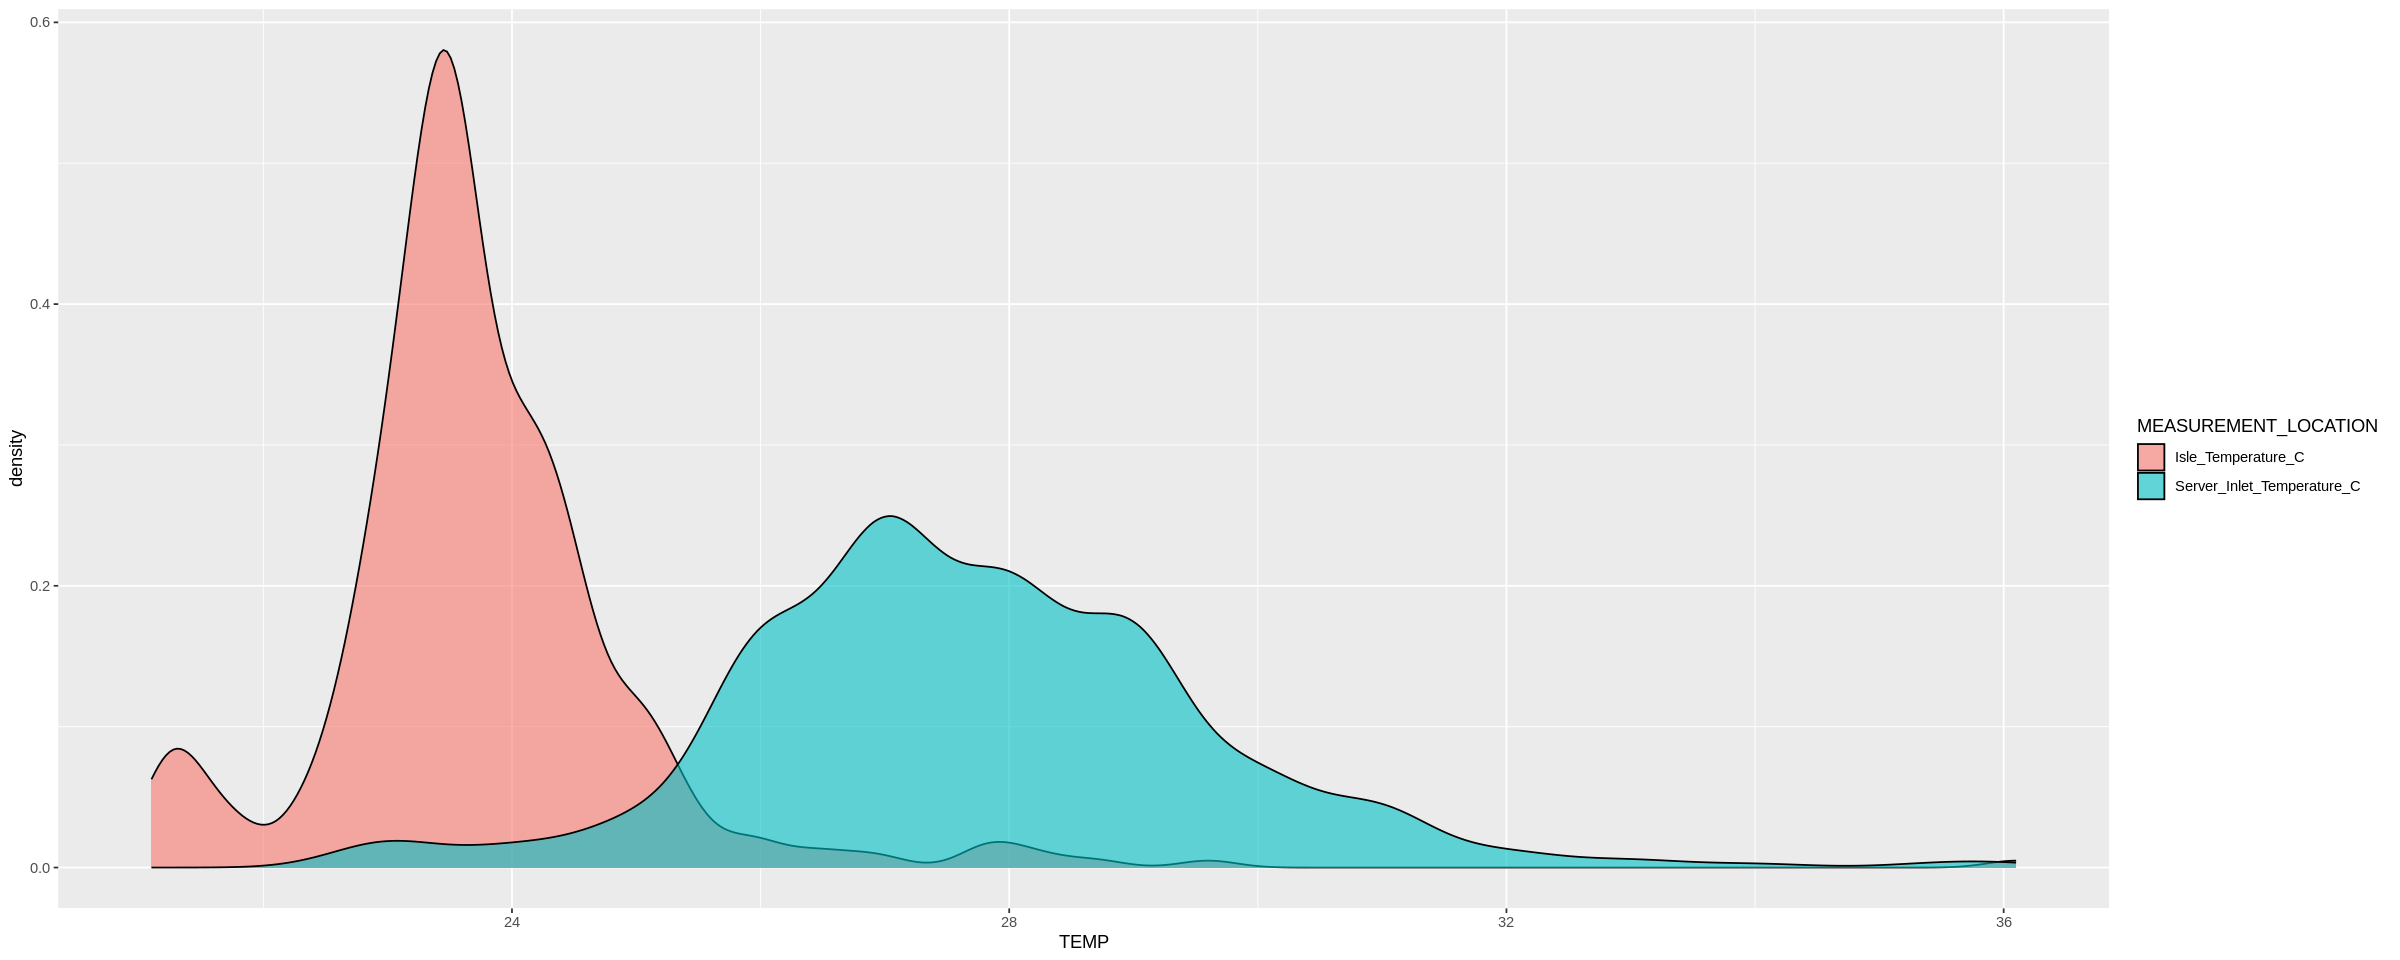

In [8]:
ggplot(df, aes(TEMP, fill = MEASUREMENT_LOCATION)) + geom_density(alpha=0.6)

### Boxplot measurements are another greaet way of visualizing the data. It's easier to see the outliers, too. 


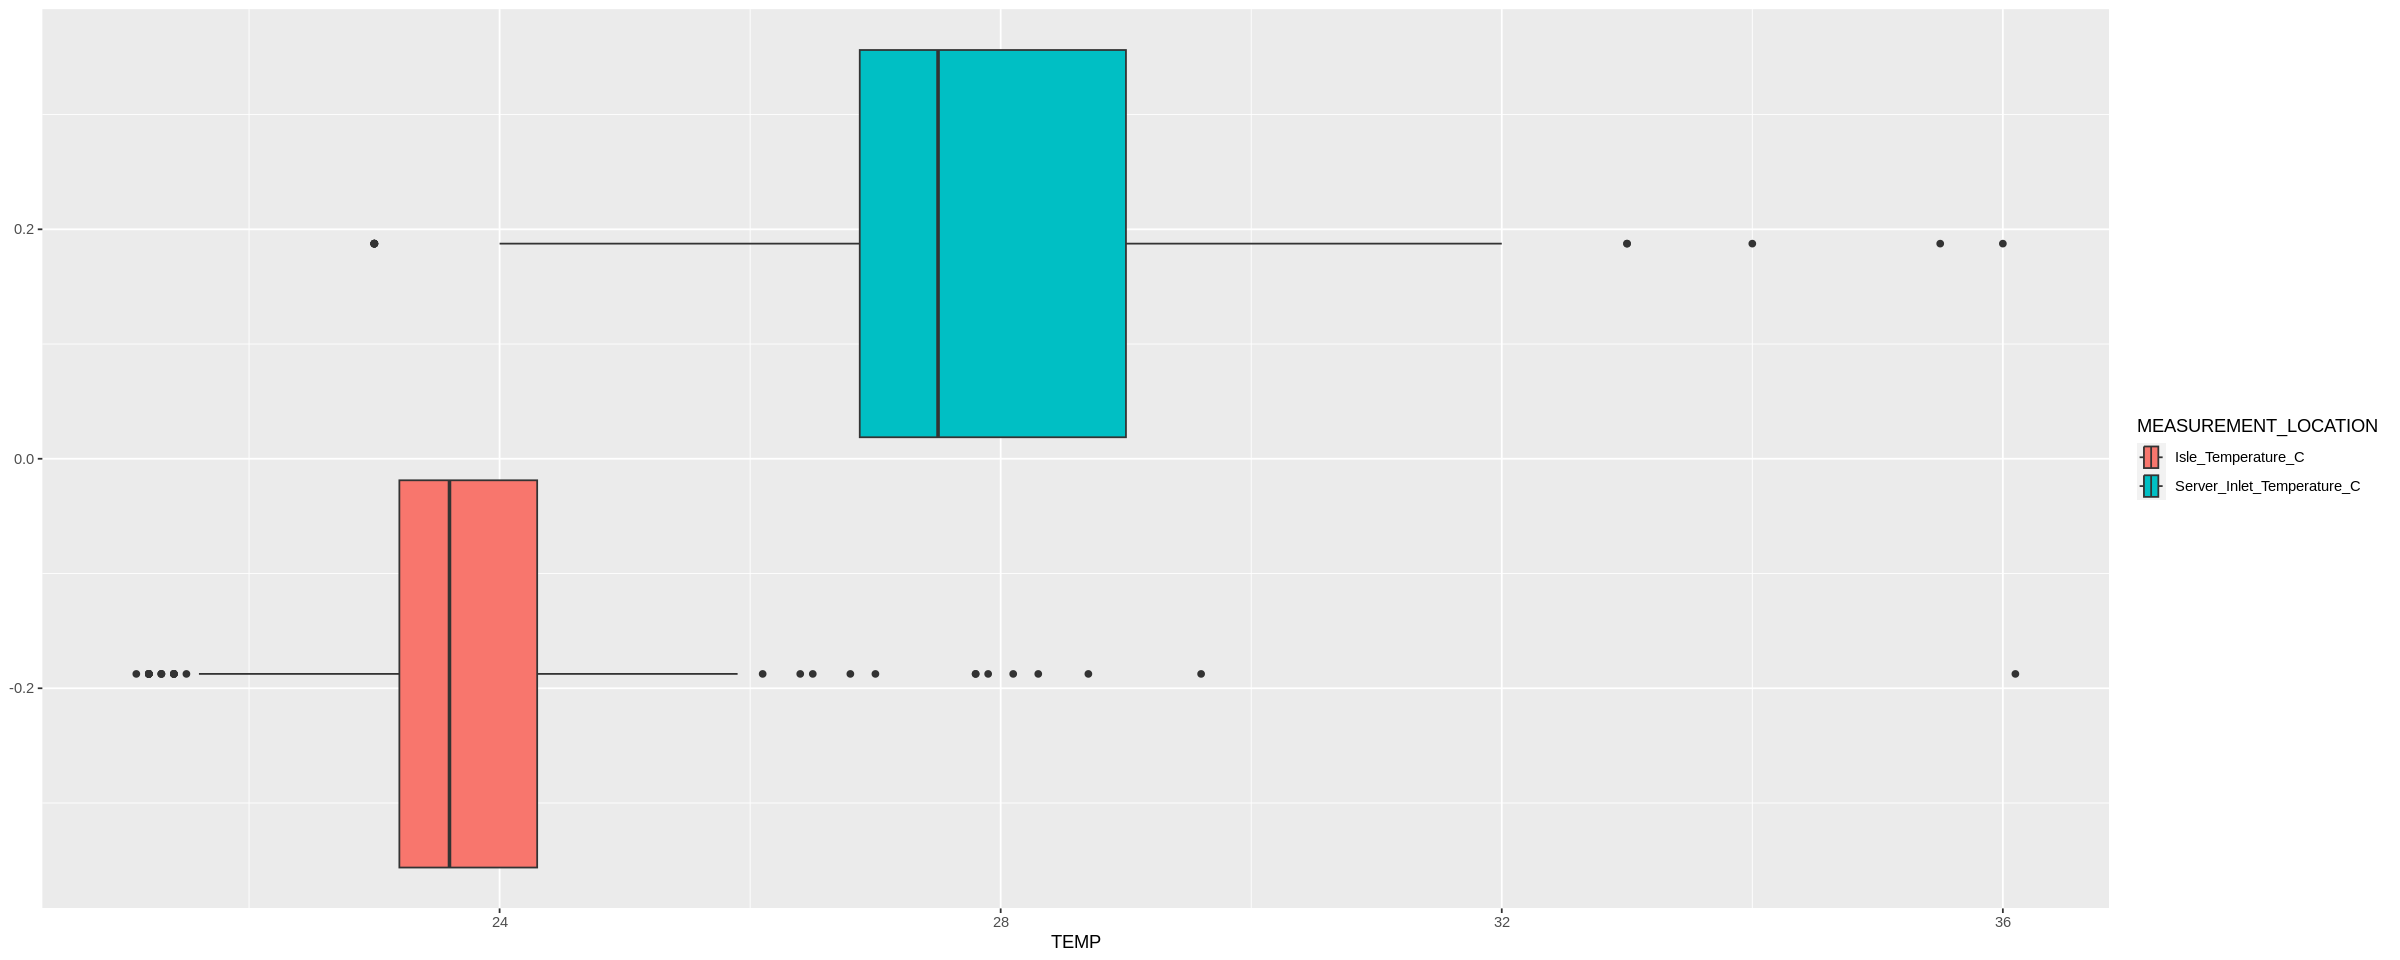

In [10]:
ggplot(df, aes(TEMP, fill = MEASUREMENT_LOCATION)) + geom_boxplot()

### Let's take a look at if there are any trends of average temperatures based on position within the row
#### What we can see is the higher the number in rack position, the higher the temperature is. This is because in this particular configuration the isle is cooled from rack position 1 upward with blowers at the start of all the rows.  

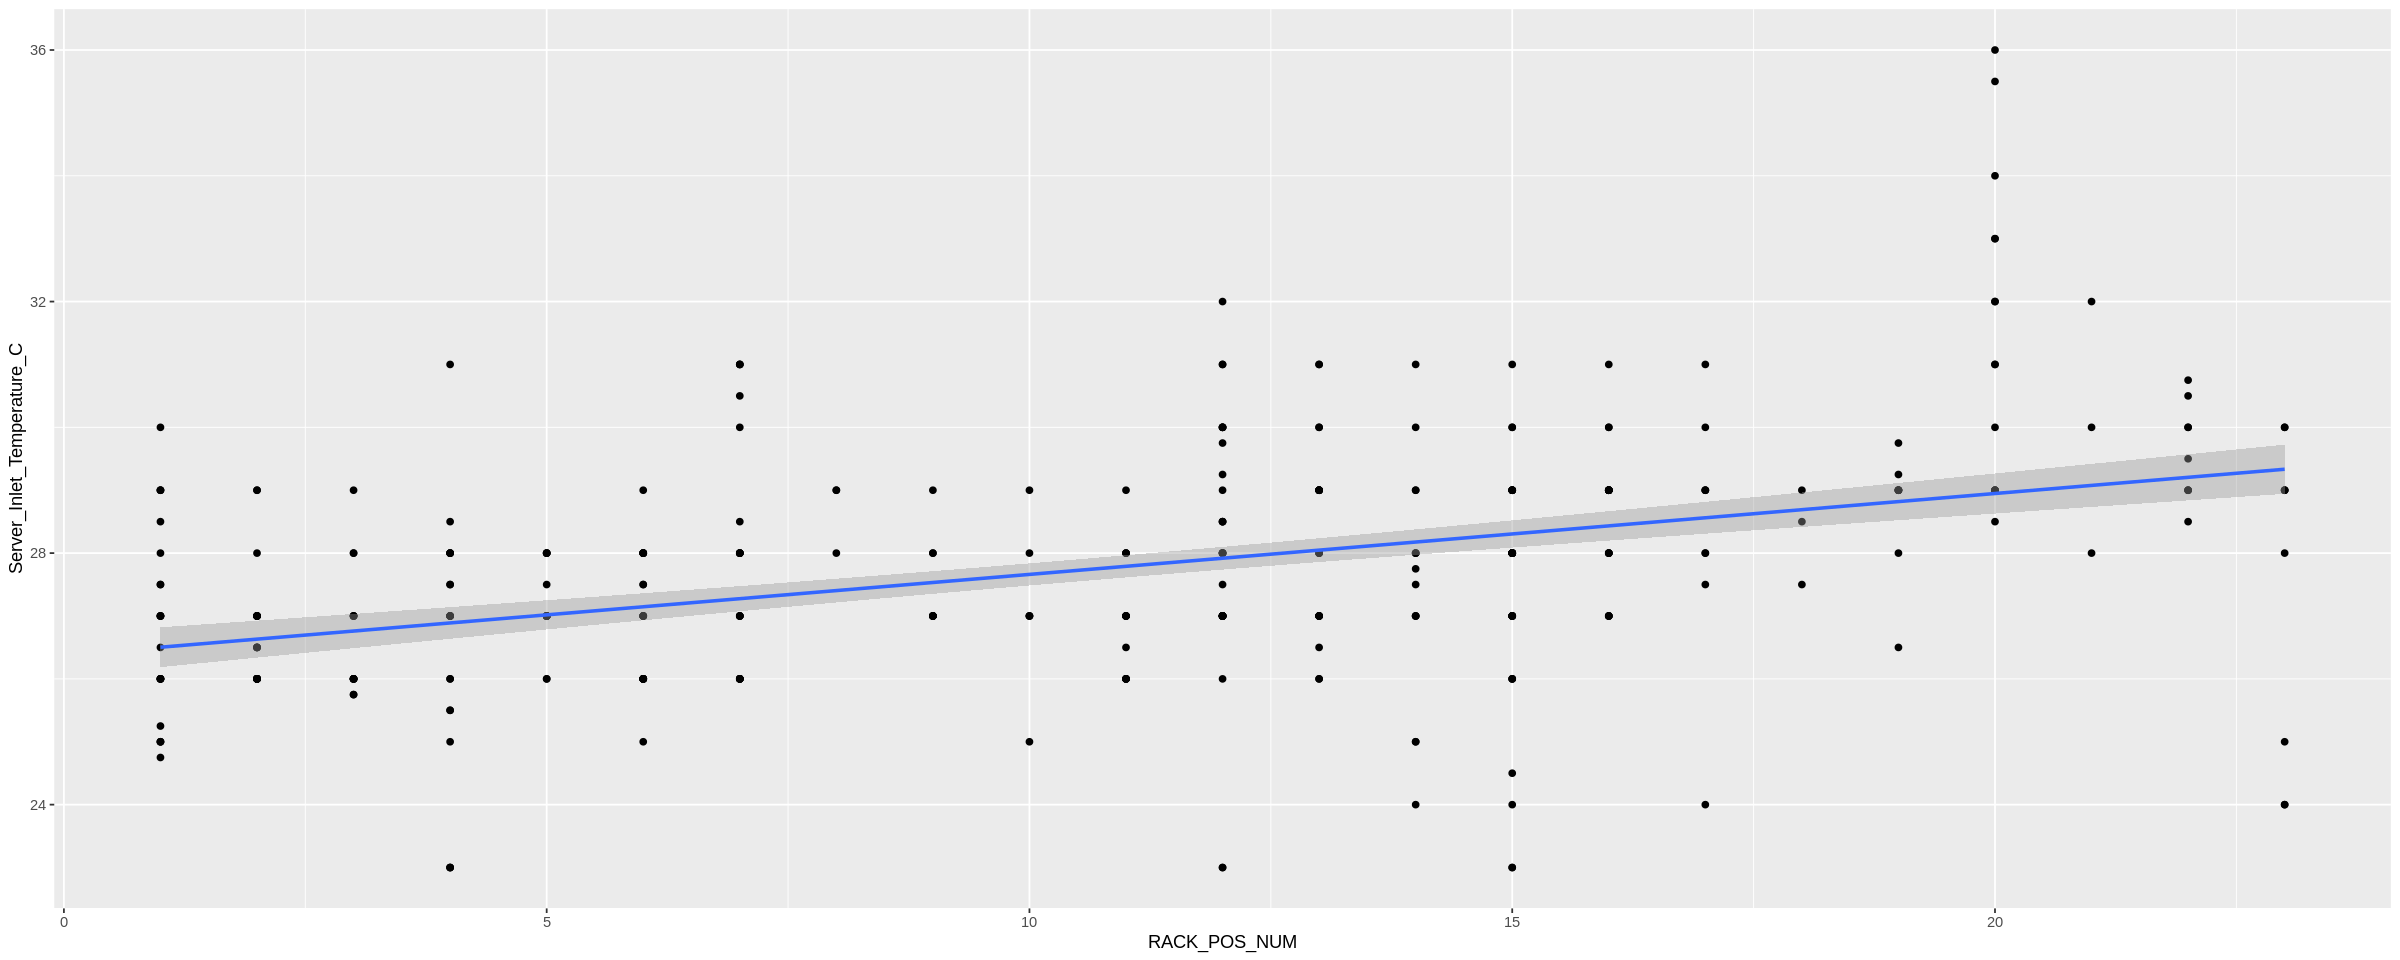

In [11]:
ggplot(original_df, aes(x=RACK_POS_NUM, y=Server_Inlet_Temperature_C)) +
    geom_point() +
    geom_smooth(method=lm) #add linear trend line

`geom_smooth()` using formula = 'y ~ x'


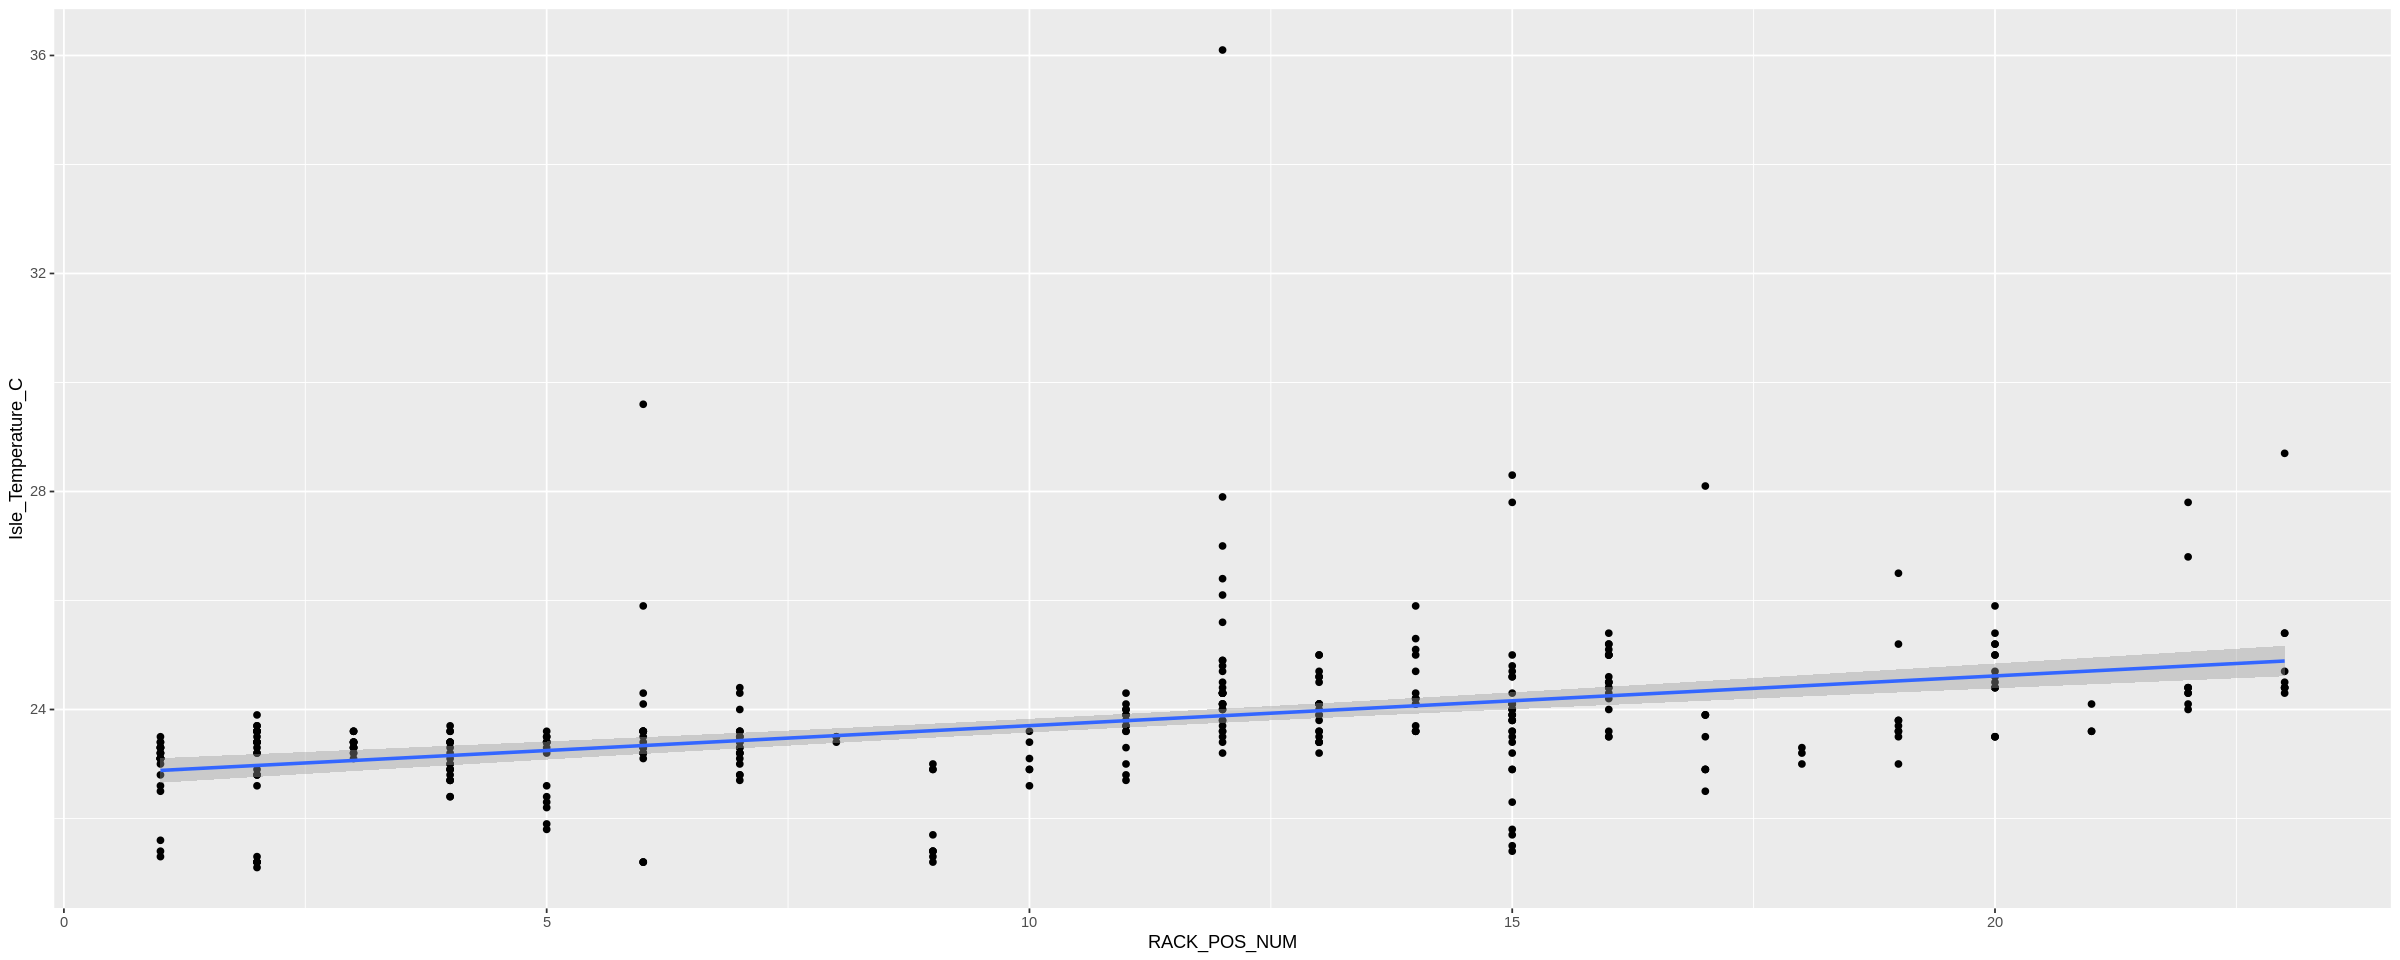

In [12]:
ggplot(original_df, aes(x=RACK_POS_NUM, y=Isle_Temperature_C)) +
    geom_point() +
    geom_smooth(method=lm) #add linear trend line

### Let's generate a list of the averages by row just so we have them, using dplyr

In [14]:
averages <- original_df %>%
    group_by(RACK_POS_NUM) %>%
    dplyr::summarize(Mean = mean(Isle_Temperature_C))

In [39]:
averages

RACK_POS_NUM,Mean
<int>,<dbl>
1,22.91667
2,22.85926
3,23.36667
4,23.07143
5,22.92667
6,23.55652
7,23.40000
8,23.46667
9,21.91111


### Again these averages trend upward

`geom_smooth()` using formula = 'y ~ x'


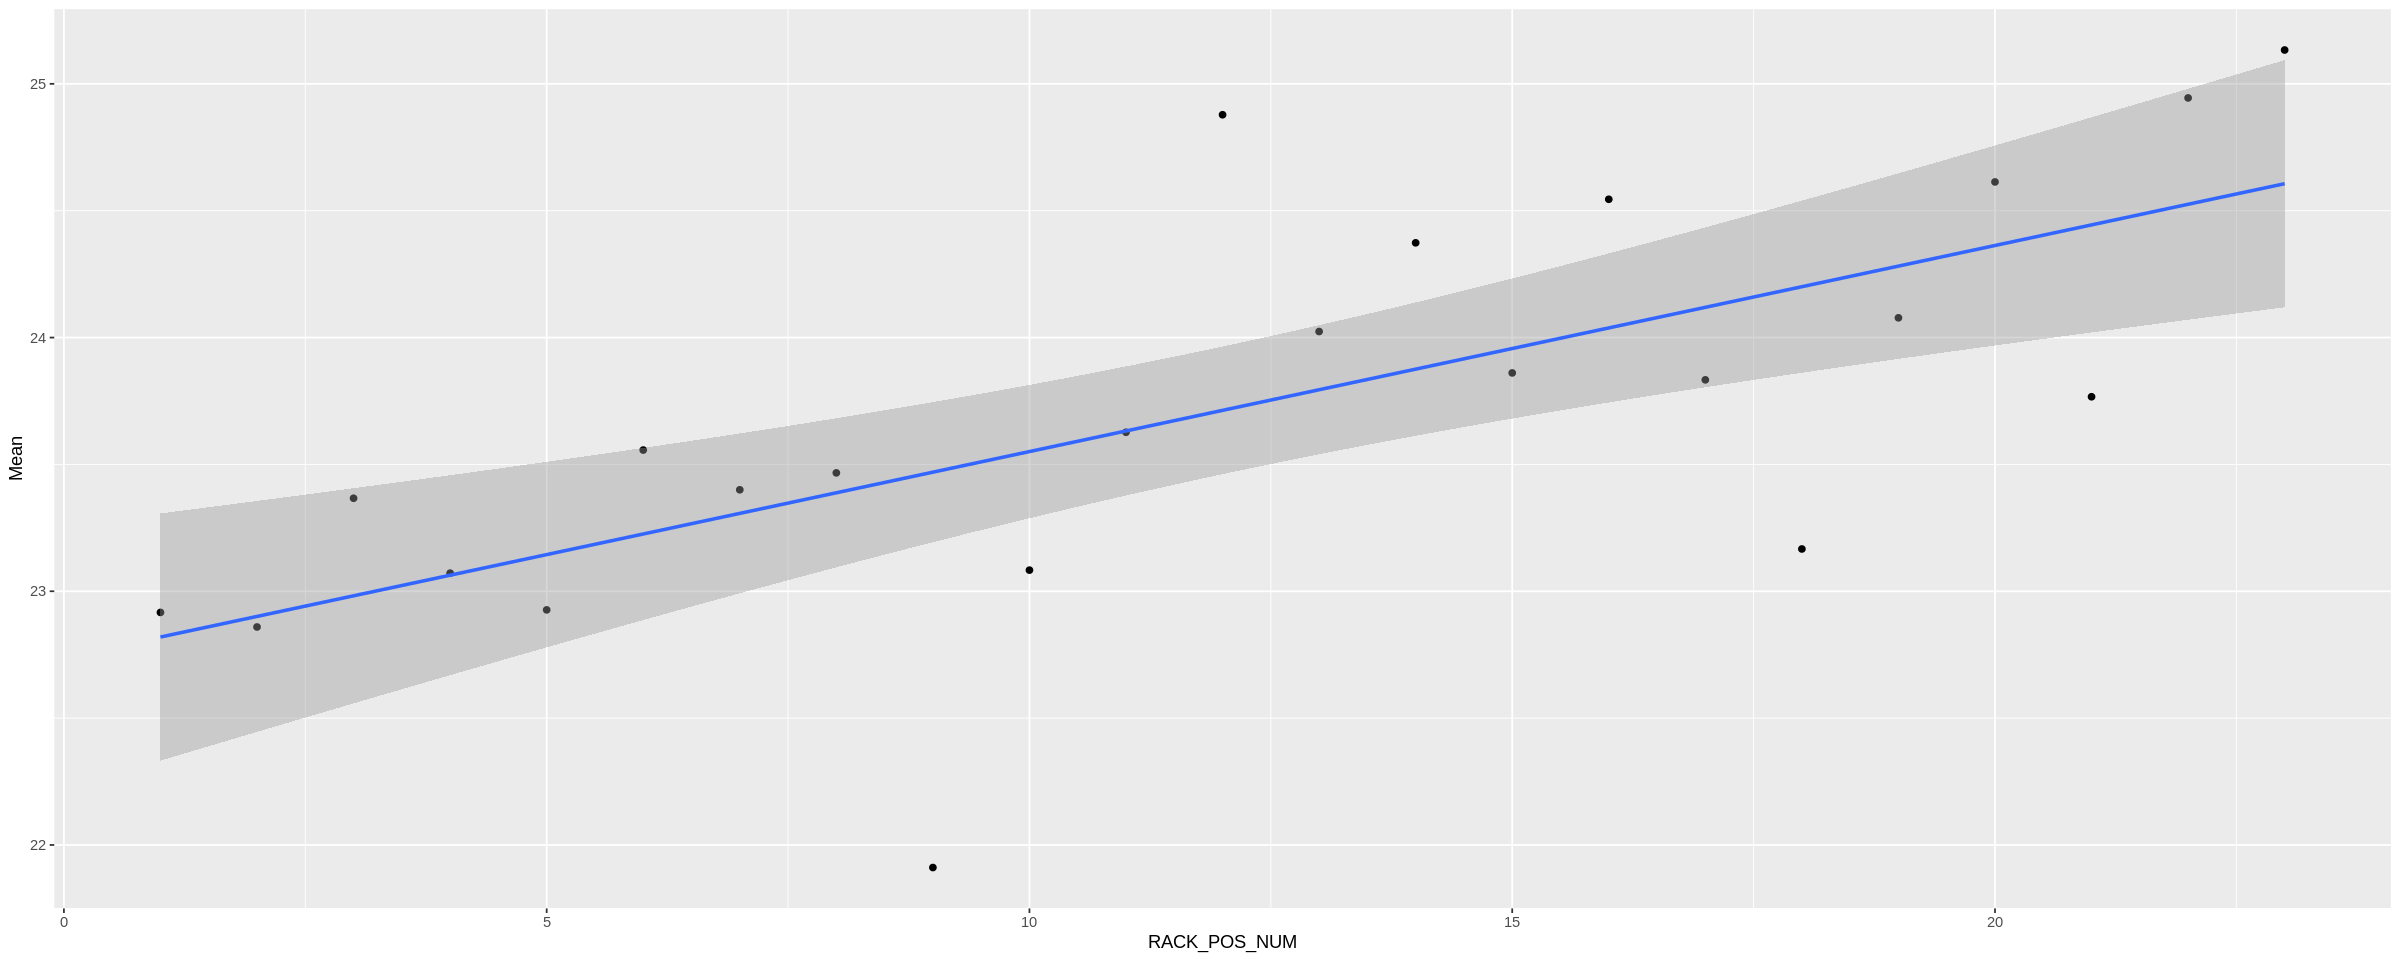

In [15]:
ggplot(averages, aes(x=RACK_POS_NUM, y=Mean)) +
    geom_point() +
    geom_smooth(method=lm) #add linear trend line

### We can do a simple linear model to express this

In [38]:
model <- lm(original_df$EXTERNAL_TEMP_C~original_df$RACK_POS_NUM)
summary(model)


Call:
lm(formula = original_df$EXTERNAL_TEMP_C ~ original_df$RACK_POS_NUM)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7595 -0.4857 -0.0157  0.4143 12.2143 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              22.79074    0.12342 184.660   <2e-16 ***
original_df$RACK_POS_NUM  0.09125    0.01012   9.015   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.207 on 355 degrees of freedom
Multiple R-squared:  0.1863,	Adjusted R-squared:  0.184 
F-statistic: 81.27 on 1 and 355 DF,  p-value: < 2.2e-16


### A question that might be asked: 
### Can we use the internal temperature sensors on a server to determine the ambient temperature of a room? The answer is really no. Based on my experience, there's too much variation and theoretically, the server itself can be creating an 'oven' effect based on the load of the system on those sensors. 

## Charts we are going to look at 
* Variance in the spread of temperature data of internal probes, they are very wide, the variation in temperature of the isle is very low
* Temperature is not dependent on the elevation location of a server on a rack
* Difference does not matter based on where in the row it is

### The inlet temperatures do have a greater variation. This is an interesting plot showing the offset and distribution of inlet temperature and external measured temperature

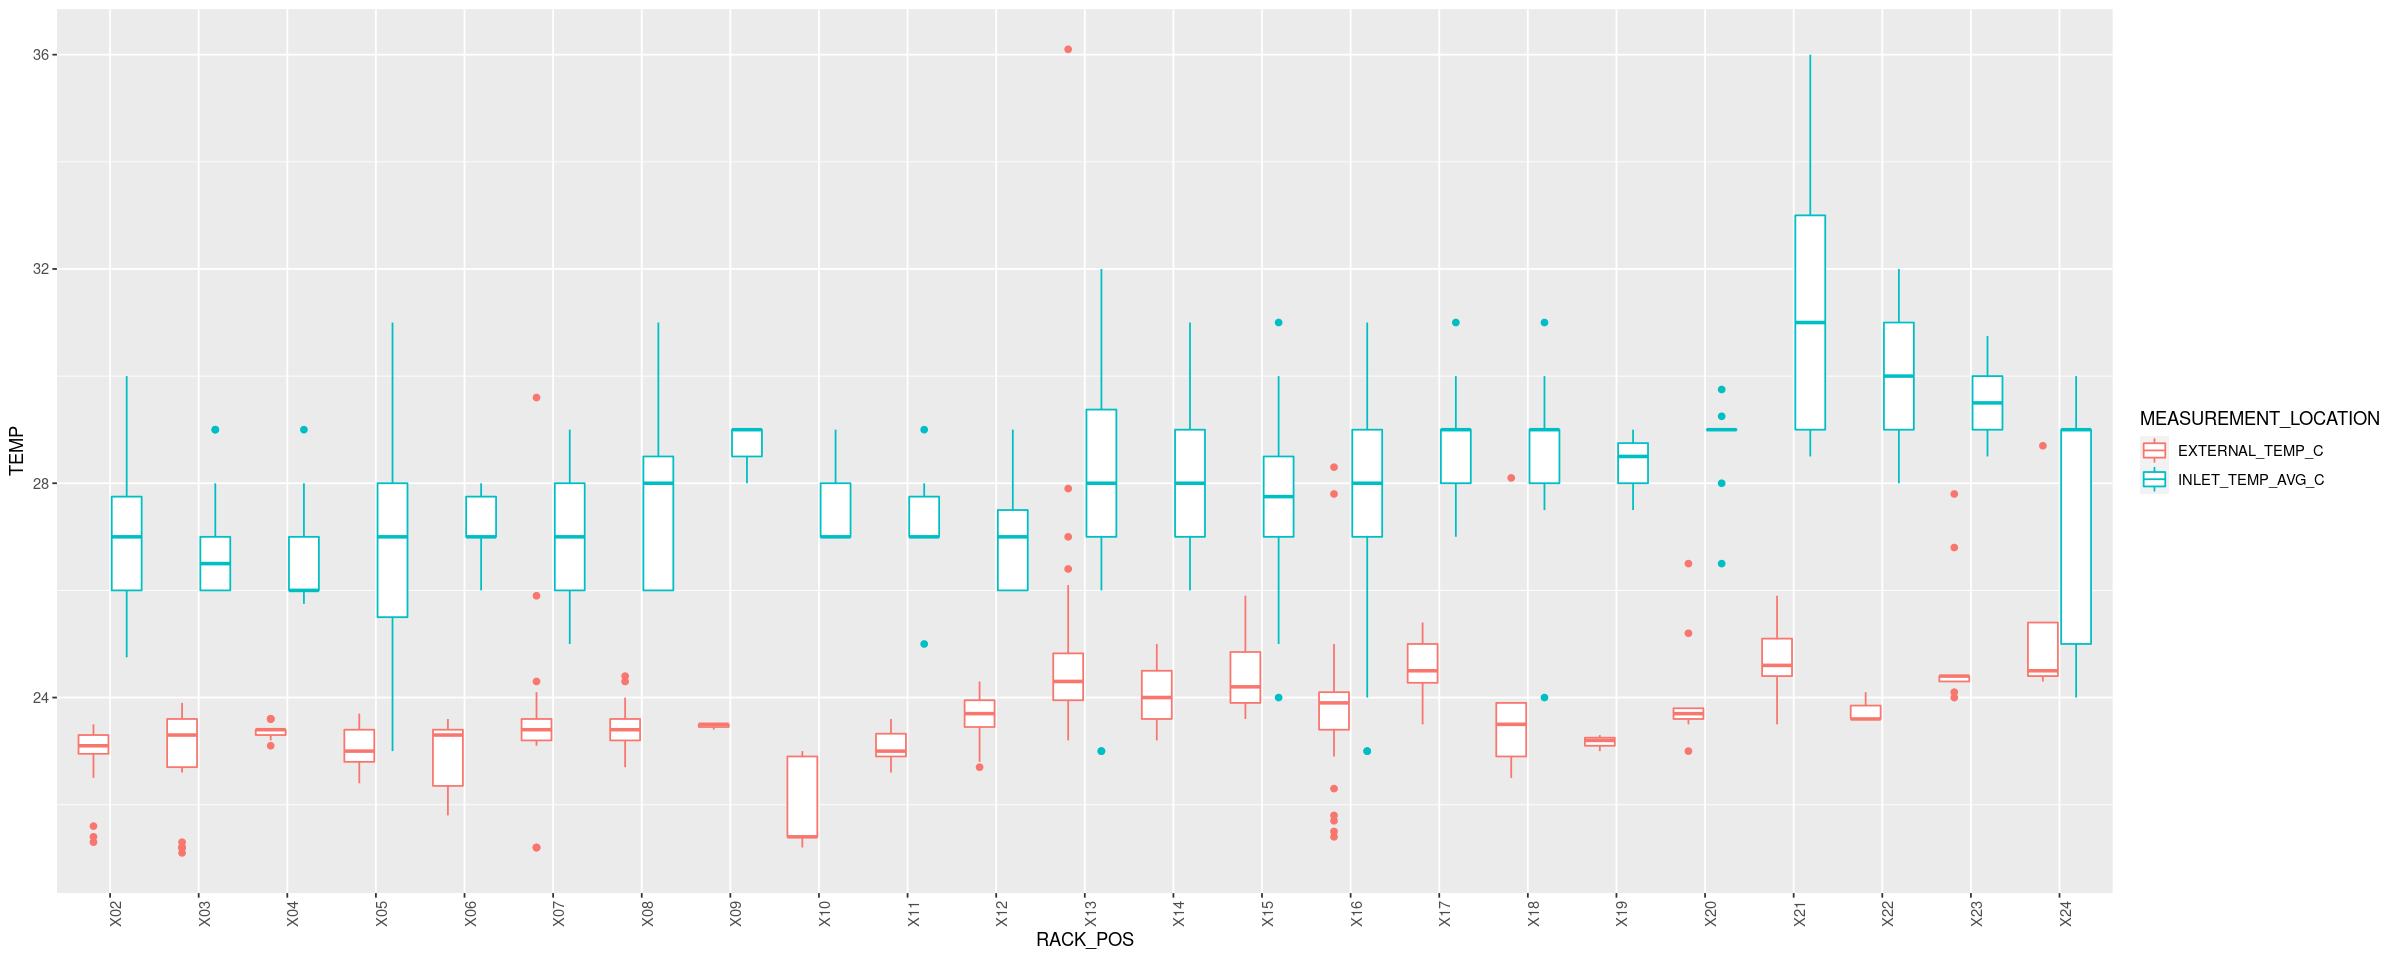

In [136]:
ggplot(df, aes(x=RACK_POS, y=TEMP, color=MEASUREMENT_LOCATION)) + geom_boxplot() + theme(axis.text.x = element_text(angle = 90))

### Is the temperature difference dependent on location in the row, by platform? No. We can see there's no discernable pattern across the rack positions

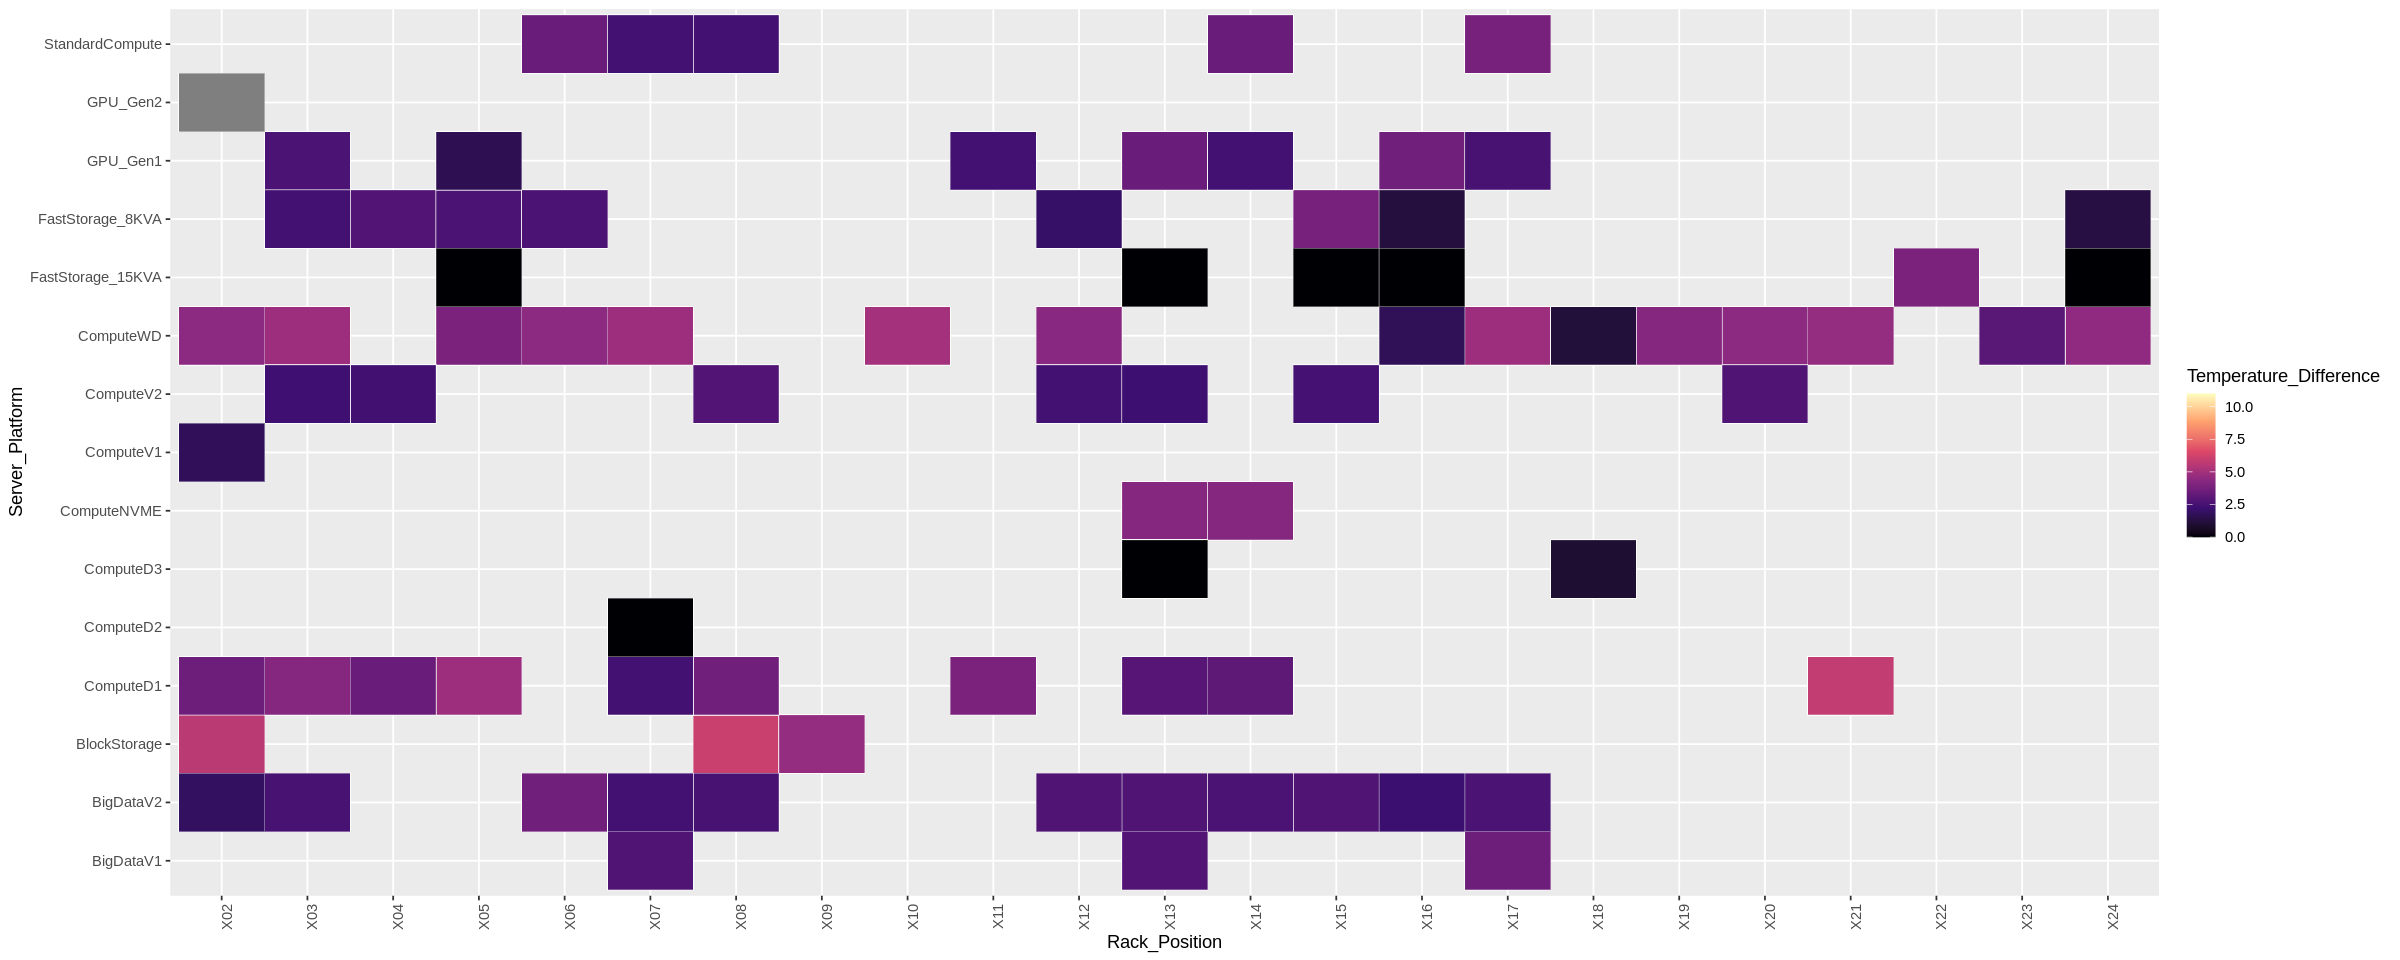

In [20]:
ggplot(df, aes(Rack_Position, Server_Platform)) +
  geom_tile(aes(fill = Temperature_Difference), colour = "white") +
    scale_fill_viridis_c(option = "magma") + 
 theme(axis.text.x = element_text(angle = 90))

## Difference in Temperature by Rack Position

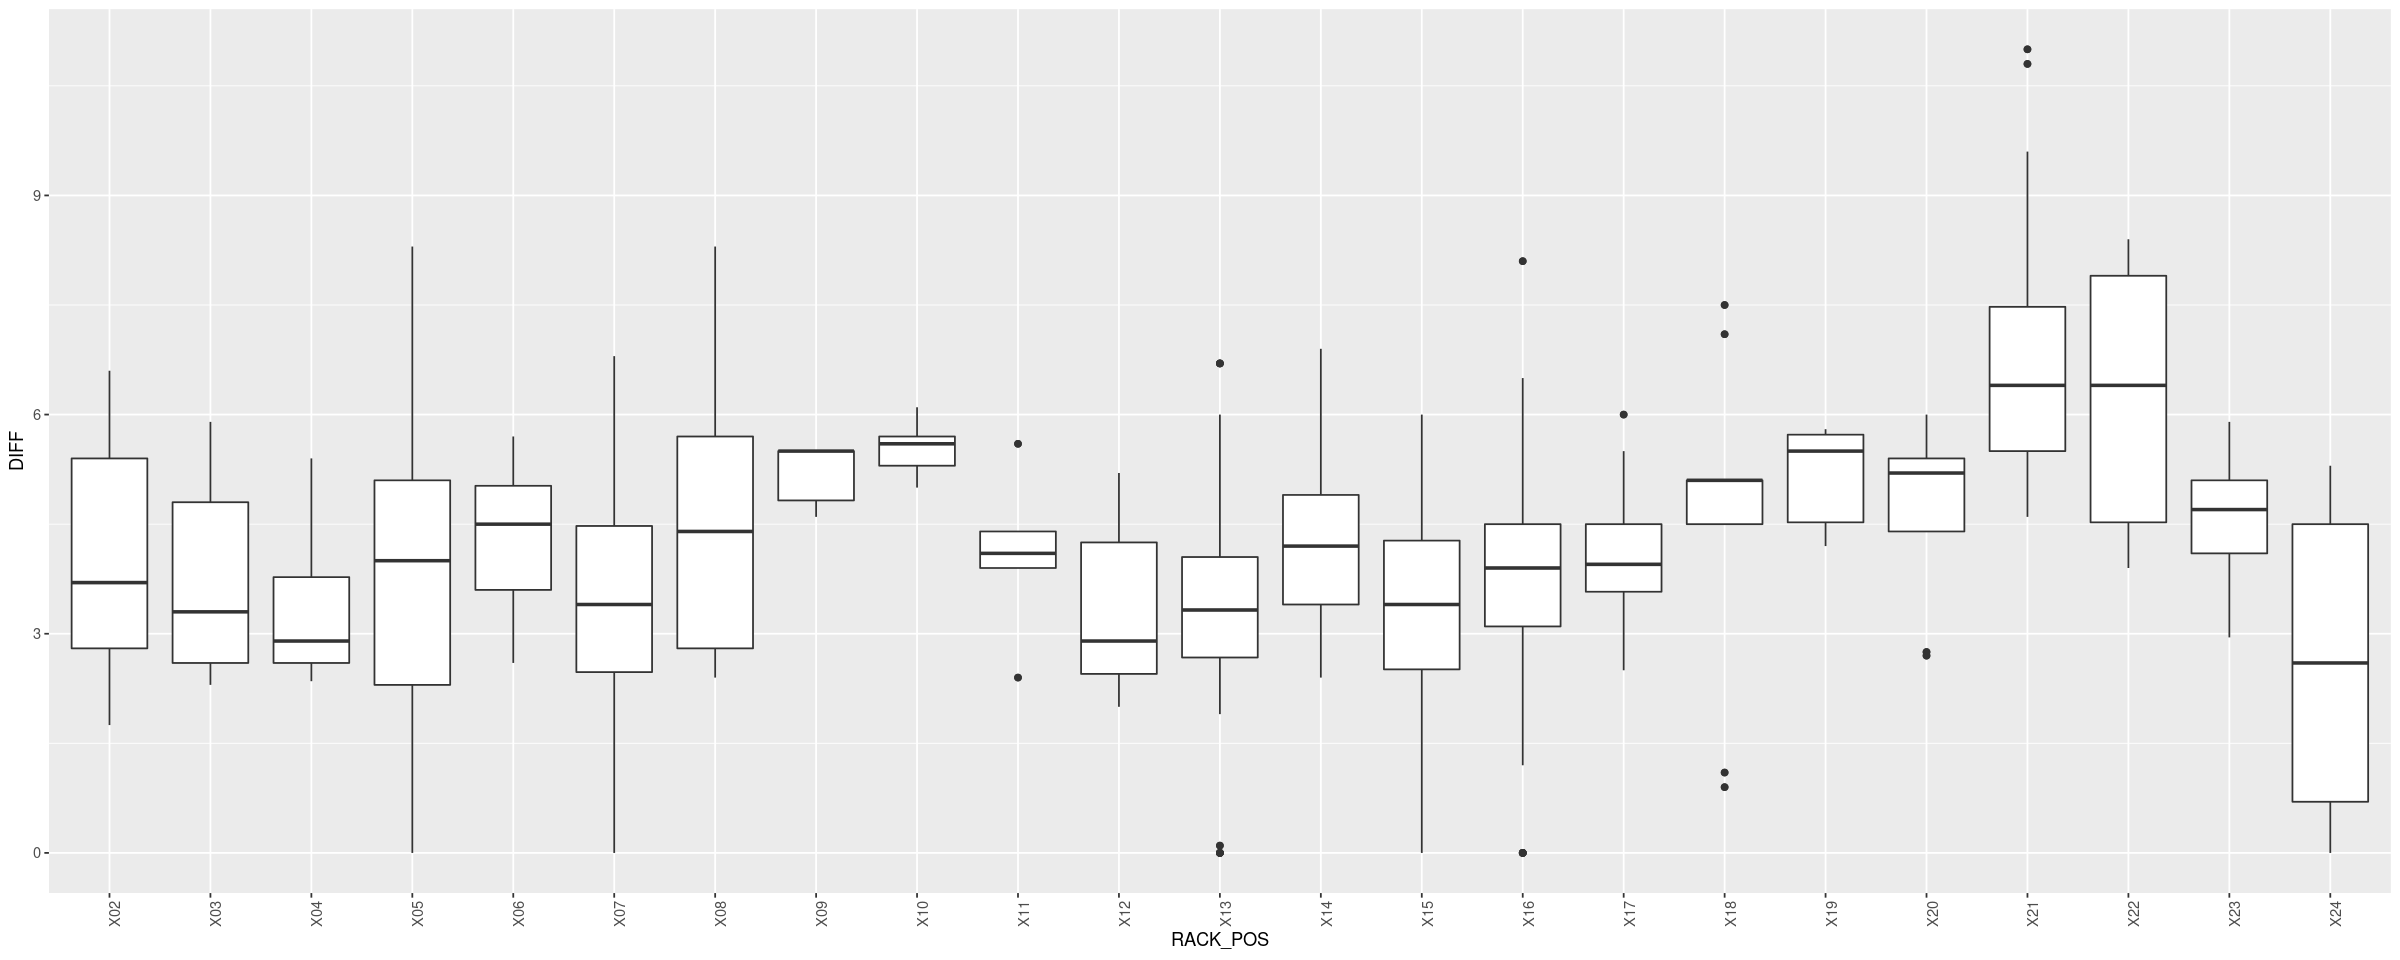

In [148]:
ggplot(df, aes(x=RACK_POS, y=DIFF)) + geom_boxplot() + theme(axis.text.x = element_text(angle = 90))

### Difference in Temperature by Platform
#### Different platforms run different loads, and because of configuration generate different amounts of heat. 

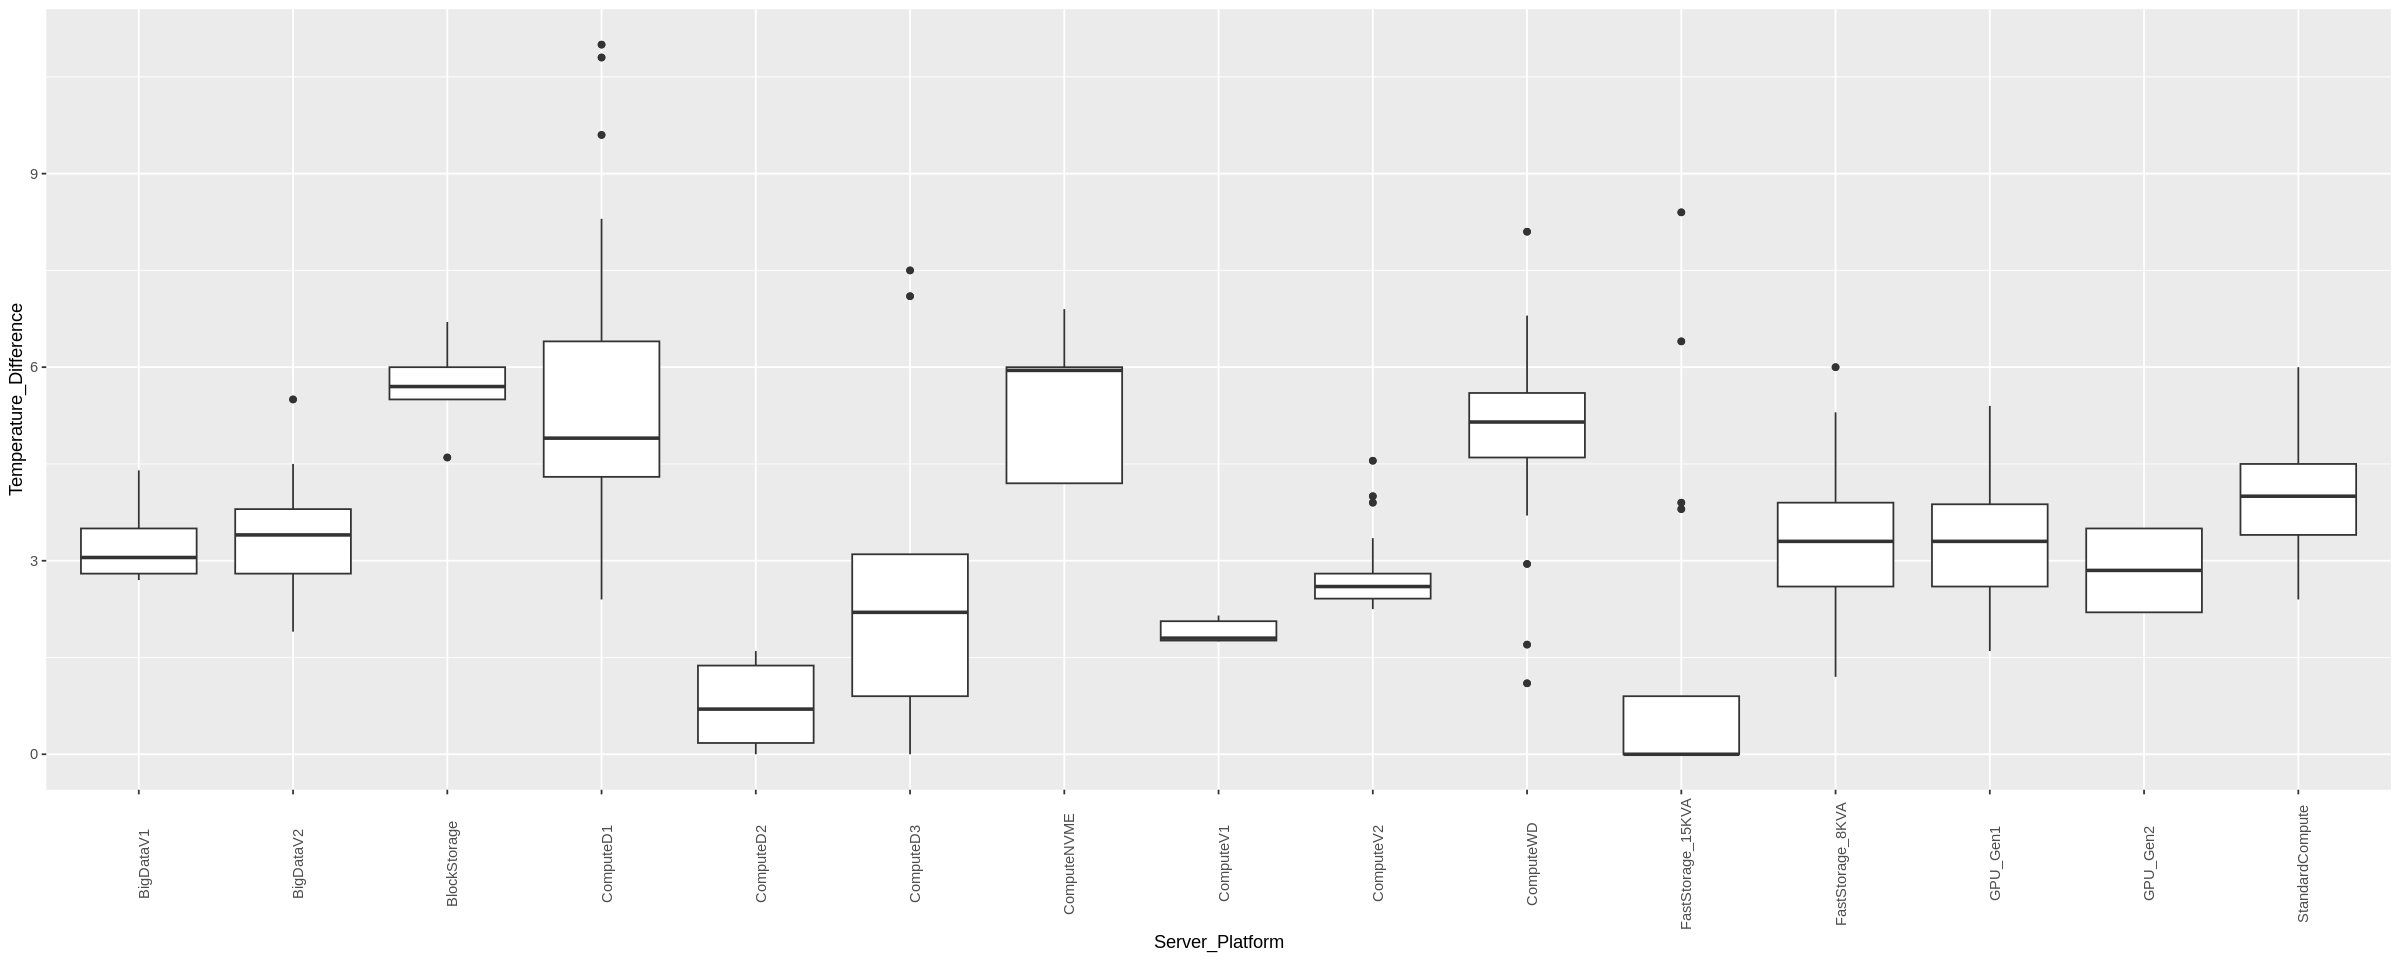

In [35]:
ggplot(df, aes(x=Server_Platform, y=Temperature_Difference)) + geom_boxplot() + theme(axis.text.x = element_text(angle = 90))

#### Is there much variation in temeprature across the front of the rack? Is it worth measuring different elevations? Here's another interesting observation. Towards the top of the racks you might see huge variations in temperature? 
#### Why? 
#### Network switches and other devices tend to be mounted towards the top. Hot air containment is not as good in these areas and air tends to get recirculated back to the front of the server

In [ ]:
p <- ggplot(original_df, aes(x=as.character(ELEVATION_NUM), y=EXTERNAL_TEMP_C)) + geom_boxplot() + theme(axis.text.x = element_text(angle = 90))

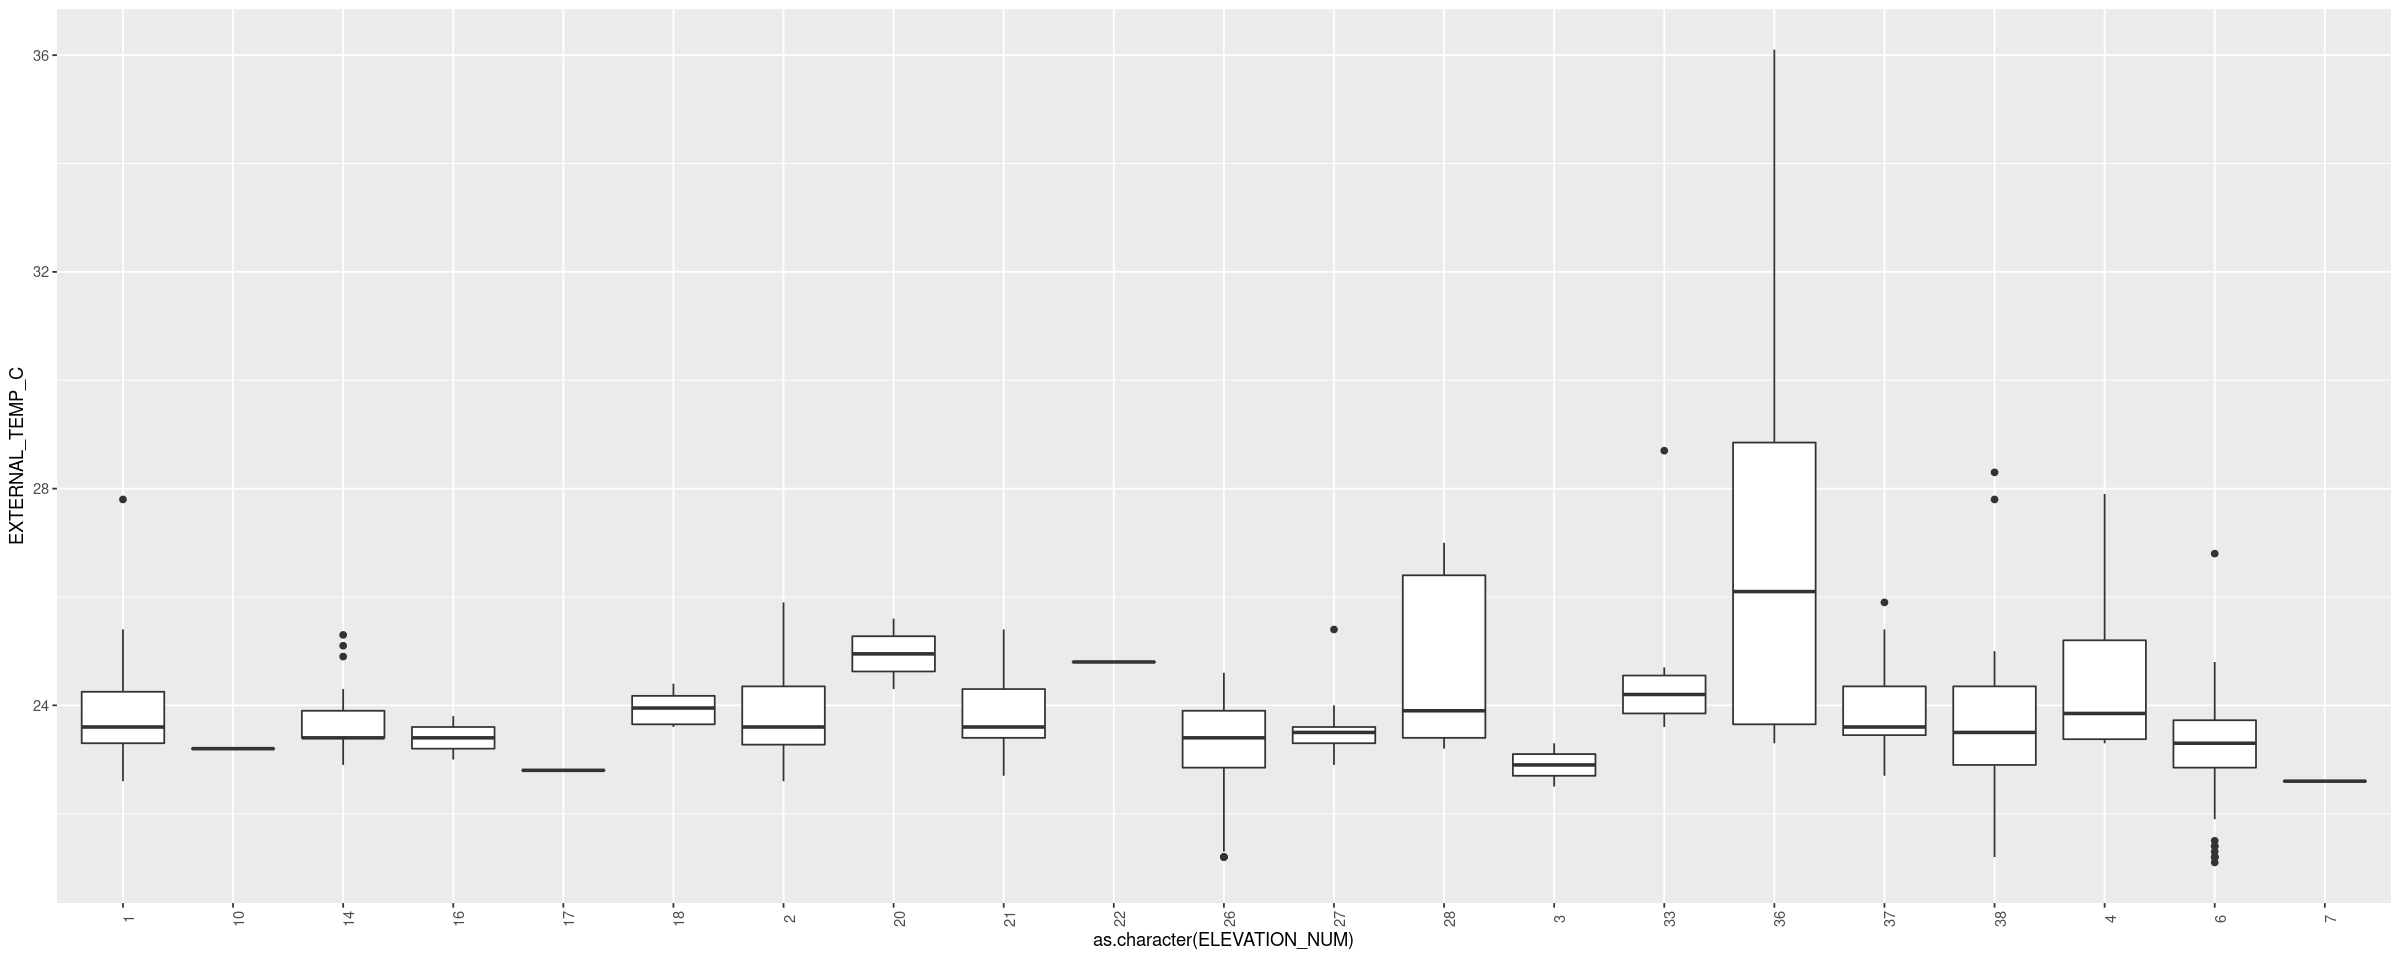

In [ ]:
p